In [ ]:
# Install necessary libraries
!pip install numpy-financial



In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv('/content/LoanData_Bondora.csv')

data['Status']= data['Status'].apply(lambda x:'Non default' if 'Repaid' in x else 'Defaulted')
# Define the target variable and features
target = data['Status']
features = data[['Amount', 'Interest', 'PrincipalPaymentsMade', 'InterestAndPenaltyDebtServicingCost',
                 'PrincipalDebtServicingCost', 'BidsPortfolioManager', 'BidsApi', 'BidsManual',
                 'IncomeTotal', 'LiabilitiesTotal']]


<ipython-input-2-adba07566568>:17: DtypeWarning: Columns (34,38,80,82,83,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/LoanData_Bondora.csv')


In [ ]:
data['Status'].value_counts()

,count
Status,
Defaulted,126348
Non default,52887


In [ ]:
# Handle any missing values in features and target
features = features.fillna(features.mean())
target = target.fillna(target.mode()[0])

# Encode the target variable if it's categorical
target = pd.factorize(target)[0]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train_binary = [0 if status in [0, 1] else 1 for status in y_train]
y_test_binary = [0 if status in [0, 1] else 1 for status in y_test]

In [ ]:
# Define input shape and number of classes
input_shape = X_train.shape[1]
num_classes = len(np.unique(y_train))

# Define the Neural Network model
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))



In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weights)

# Make predictions and evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


Epoch 1/40
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9223 - loss: 0.2168 - val_accuracy: 0.9603 - val_loss: 0.1522
Epoch 2/40
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9559 - loss: 0.1399 - val_accuracy: 0.9743 - val_loss: 0.0832
Epoch 3/40
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9587 - loss: 0.1327 - val_accuracy: 0.9759 - val_loss: 0.0683
Epoch 4/40
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9589 - loss: 0.1332 - val_accuracy: 0.9765 - val_loss: 0.0709
Epoch 5/40
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9624 - loss: 0.1212 - val_accuracy: 0.9762 - val_loss: 0.0758
Epoch 6/40
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9644 - loss: 0.1162 - val_accuracy: 0.9768 - val_loss: 0.0804
Epoch 7/40
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9660 - loss: 0.1140 - val_accuracy: 0.9765 - val_loss: 0.0793
Epoch 8/40
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9668 - loss: 

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Model Accuracy: 97.93%


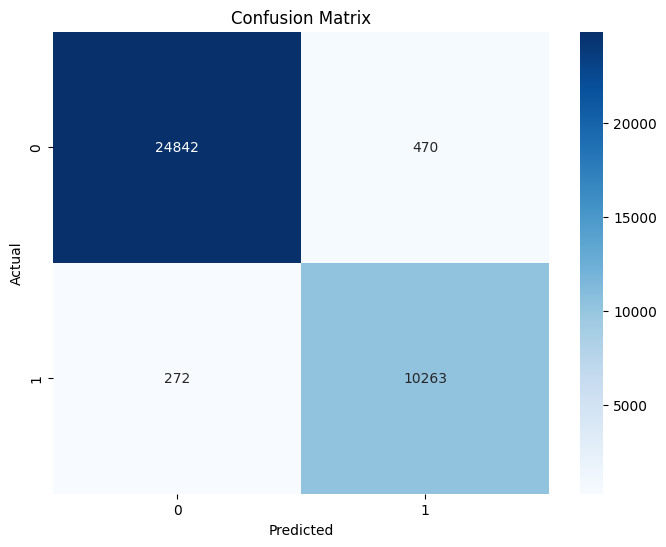

In [ ]:
# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Model Accuracy: {accuracy * 100:.2f}%")
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
import numpy_financial as npf
# Define functions to calculate IRR and ERR
def calculate_irr(principal, cash_flows, recovery_amount=0):
    # Adjust the cash flow sequence to include recovery if defaulted
    if recovery_amount > 0:
        cash_flows[-1] += recovery_amount
    # Calculate IRR; npf.irr expects a list of cash flows starting with the initial negative investment
    irr = npf.irr([-principal] + cash_flows)
    return irr * 12  # Annualize IRR

def calculate_err(principal, cash_flows, term, risk_free_rate=0.01, recovery_amount=0, default_occurred=False):
    FV = 0  # Initialize future value at term end
    for i, cash_flow in enumerate(cash_flows):
        # Calculate future value by reinvesting each cash flow at the risk-free rate until end of term
        if cash_flow != 0:
            FV += cash_flow * np.prod([1 + risk_free_rate / 12 for _ in range(i+1, term)])
    if default_occurred:
        FV += recovery_amount  # Add recovery amount if defaulted
    # Calculate ERR
    err = (FV / principal) ** (12 / term) - 1
    return err

# Generate IRR and ERR for each loan based on cash flows and term
data['IRR'] = data.apply(lambda row: calculate_irr(row['Amount'], [row['PrincipalPaymentsMade']], row.get('RecoveryAmount', 0)), axis=1)
data['ERR'] = data.apply(lambda row: calculate_err(row['Amount'], [row['PrincipalPaymentsMade']], term=36, risk_free_rate=0.01, recovery_amount=row.get('RecoveryAmount', 0), default_occurred=row['Status'] == 'Defaulted'), axis=1)

# Identify top 20 loans by ERR
top_loans_by_err = data.nlargest(20, 'ERR')
print("Top 20 Loans by ERR:")
print(top_loans_by_err[['Amount', 'IRR', 'ERR']])

Top 20 Loans by ERR:
          Amount       IRR       ERR
2158    447.3996  0.917301  0.034866
25496   530.0000  0.267396  0.017211
3817   1050.0000  0.030514  0.010621
3055    900.0000  0.026267  0.010502
4035    700.0000  0.021771  0.010376
1666    249.2513  0.000000  0.009766
7      1000.0000  0.000000  0.009766
8      4000.0000  0.000000  0.009766
9      5000.0000  0.000000  0.009766
10     2000.0000  0.000000  0.009766
11      530.0000  0.000000  0.009766
12     5500.0000  0.000000  0.009766
13     6900.0000  0.000000  0.009766
16      530.0000  0.000000  0.009766
18     3720.0000  0.000000  0.009766
28     1595.0000  0.000000  0.009766
29     1500.0000  0.000000  0.009766
33     1000.0000  0.000000  0.009766
36     4785.0000  0.000000  0.009766
39      500.0000  0.000000  0.009766


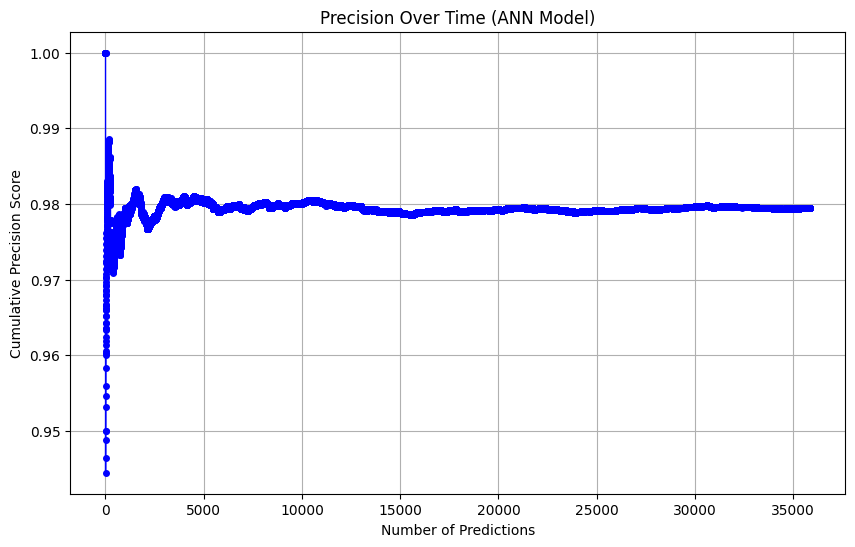

In [ ]:
# Precision over time (cumulative)
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

# Initialize an empty list to store precision scores at each step
precision_scores = []
interval = 10

# Iterate over a range to simulate time-series precision measurement
for i in range(1, len(y_test)):
    # Calculate precision for the subset of predictions up to index i
    precision = precision_score(y_test[:i], y_pred[:i], average='weighted')
    precision_scores.append(precision)

# Plot the precision over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(y_test)), precision_scores, color='blue', marker='o', linestyle='-', linewidth=1, markersize=4)
plt.xlabel('Number of Predictions')
plt.ylabel('Cumulative Precision Score')
plt.title('Precision Over Time (ANN Model)')
plt.grid(True)
plt.show()
